In [21]:
import random
import numpy as np
import matplotlib.pyplot as plt
from micrograd.micrograd.engine import Value
from micrograd.micrograd.nn import Neuron, Layer, MLP
np.random.seed(1337)
random.seed(1337)

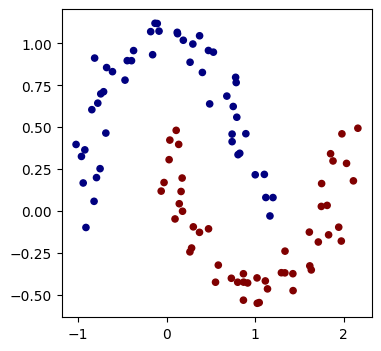

In [22]:
# make up a dataset
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 -1  # make y be -1 or 1
# X.shape = (100,2), X = array([[a,b], [a,b], ...])
# y.shape = (100,), y = array([1,1,0,0,1...])
# X和y都是NumPy数组(numpy.ndarray), 是python机器学习常用数据格式。nd=N-dimensional, ndarray就是“N维数组”的意思。

# visualize in 2D
plt.figure(figsize=(4,4))  # 创建一个新的图形窗口，窗口大小5x5英寸。
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
# 取X第一列作为x坐标，X的第二列作为y坐标，c=y表示用y的值给点着色，s=20表示点的大小为20，cmap='jet'使用'jet'颜色映射

In [23]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-(hidden) layer neural network
print(model)
# MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
# ReLUNeuron(2) 表示当前Neuron有2个输入(2个w参数), 且经过了ReLU函数的激活。
# Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)] 表示当前Layer有3个Neuron, 输入维度为2, 输出维度为3。
print("number of parameters", len(model.parameters()))
# number of parameters 337
# parameters = model.parameters()  # list, len=337
# print(parameters)

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
